In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

2025-02-13 19:44:20.681461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739475860.701681  186754 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739475860.707790  186754 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 19:44:20.732386: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def load_prot_t5_data(pos_file, neg_file):
    """Load ProtT5 embeddings and align with existing data"""
    # Read positive and negative files
    pos_data = []
    with open(pos_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            pos_data.append((entry, pos, embeddings))
            
    neg_data = []
    with open(neg_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            neg_data.append((entry, pos, embeddings))
    
    # Convert to dictionaries for easy lookup
    pos_dict = {(entry, pos): emb for entry, pos, emb in pos_data}
    neg_dict = {(entry, pos): emb for entry, pos, emb in neg_data}
    
    return pos_dict, neg_dict

In [4]:
def prepare_aligned_data(seq_struct_df, pos_dict, neg_dict):
    """Align ProtT5 embeddings with sequence+structure data"""
    embeddings = []
    aligned_indices = []
    
    for idx, row in seq_struct_df.iterrows():
        key = (row['entry'], row['pos'])
        emb = pos_dict.get(key) if row['label'] == 1 else neg_dict.get(key)
        
        if emb is not None:
            embeddings.append(emb)
            aligned_indices.append(idx)
    
    # Convert to numpy array
    X_prot_t5 = np.array(embeddings)
    
    # Get aligned sequence+structure data
    aligned_df = seq_struct_df.iloc[aligned_indices]
    
    return X_prot_t5, aligned_df

In [5]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [ ]:
def create_seq_prot_t5_model(seq_length=33):
    """Create model with sequence and ProtT5 tracks"""

    regularizer = tf.keras.regularizers.l2(0.01)

    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 8, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Conv1D(32, kernel_size=7, activation='relu', padding='same')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.MaxPooling1D(pool_size=2)(x_seq)
    x_seq = tf.keras.layers.Dropout(0.3)(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizer, name='seq_features')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.3)(x_seq)

    # ProtT5 track
    prot_t5_input = tf.keras.layers.Input(shape=(1024,), name='prot_t5_input')
    x_prot_t5 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer)(prot_t5_input)
    x_prot_t5 = tf.keras.layers.Dropout(0.3)(x_prot_t5)

    # Create learnable weights layer for two tracks
    weight_layer = tf.keras.layers.Dense(2, activation='softmax', name='track_weights')
    track_weights = weight_layer(tf.keras.layers.Concatenate()([x_seq, x_prot_t5]))

    # Apply weights
    weighted_seq = tf.keras.layers.Multiply(name='weighted_seq')([
        x_seq,
        tf.keras.layers.Lambda(lambda x: x[:, 0:1])(track_weights)
    ])
    
    weighted_prot_t5 = tf.keras.layers.Multiply(name='weighted_prot_t5')([
        x_prot_t5,
        tf.keras.layers.Lambda(lambda x: x[:, 1:2])(track_weights)
    ])

    # Combine features
    combined = tf.keras.layers.Concatenate()([weighted_seq, weighted_prot_t5])

    # Final layers with more regularization
    x = tf.keras.layers.Dense(64, activation='relu', 
                            kernel_regularizer=regularizer)(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(32, activation='relu', 
                            kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[seq_input, prot_t5_input], outputs=outputs)

    def get_track_weights():
        w = model.get_layer('track_weights').get_weights()
        if len(w) > 0:
            weights = w[0]
            bias = w[1] if len(w) > 1 else 0
            exp_weights = np.exp(np.mean(weights, axis=0) + bias)
            normalized = exp_weights / np.sum(exp_weights)
            return {
                'sequence': float(normalized[0]),
                'prot_t5': float(normalized[1])
            }
        return {'sequence': 0.5, 'prot_t5': 0.5}

    model.get_track_weights = get_track_weights
    return model

In [ ]:
def train_and_evaluate():
    """Training function with track weights"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../../data/train/structure/processed_features_train.csv")
    test_df = pd.read_csv("../../data/test/structure/processed_features_test.csv")
    
    # Load ProtT5 embeddings
    print("Loading ProtT5 embeddings...")
    train_pos_dict, train_neg_dict = load_prot_t5_data(
        '../../data/train/PLM/train_positive_ProtT5-XL-UniRef50.csv',
        '../../data/train/PLM/train_negative_ProtT5-XL-UniRef50.csv'
    )
    test_pos_dict, test_neg_dict = load_prot_t5_data(
        '../../data/test/PLM/test_positive_ProtT5-XL-UniRef50.csv',
        '../../data/test/PLM/test_negative_ProtT5-XL-UniRef50.csv'
    )
    
    # Align data
    print("Aligning data...")
    X_train_prot_t5, train_df_aligned = prepare_aligned_data(train_df, train_pos_dict, train_neg_dict)
    X_test_prot_t5, test_df_aligned = prepare_aligned_data(test_df, test_pos_dict, test_neg_dict)
    
    # Prepare sequence data
    X_train_seq = prepare_sequence_data(train_df_aligned)
    X_test_seq = prepare_sequence_data(test_df_aligned)
    
    y_train = train_df_aligned['label'].values
    y_test = test_df_aligned['label'].values
    
    # Print class distribution
    print("\nTraining set distribution:")
    print(train_df_aligned['label'].value_counts())
    print("\nTest set distribution:")
    print(test_df_aligned['label'].value_counts())
    
    # Print data shapes
    print("\nData shapes:")
    print(f"X_train_seq: {X_train_seq.shape}")
    print(f"X_train_prot_t5: {X_train_prot_t5.shape}")
    print(f"X_test_seq: {X_test_seq.shape}")
    print(f"X_test_prot_t5: {X_test_prot_t5.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    track_weights_history = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_seq_prot_t5_model(seq_length=33)
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [X_train_seq[train_idx], X_train_prot_t5[train_idx]], 
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_prot_t5[val_idx]], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict([X_train_seq[val_idx], X_train_prot_t5[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))  # Sensitivity
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))  # Specificity
        
        # Predict on test set
        test_pred = model.predict([X_test_seq, X_test_prot_t5])
        test_predictions.append(test_pred)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
        
        # After training, get and store the learned weights
        final_weights = model.get_track_weights()
        track_weights_history.append(final_weights)
        print(f"\nLearned track weights for fold {fold}:")
        print(f"Sequence weight: {final_weights['sequence']:.4f}")
        print(f"ProtT5 weight: {final_weights['prot_t5']:.4f}")
    
    # Calculate average weights
    avg_seq_weight = np.mean([w['sequence'] for w in track_weights_history])
    avg_prot_t5_weight = np.mean([w['prot_t5'] for w in track_weights_history])
    std_seq_weight = np.std([w['sequence'] for w in track_weights_history])
    std_prot_t5_weight = np.std([w['prot_t5'] for w in track_weights_history])
    
    print("\nAverage track weights across folds:")
    print(f"Sequence weight: {avg_seq_weight:.4f} ± {std_seq_weight:.4f}")
    print(f"ProtT5 weight: {avg_prot_t5_weight:.4f} ± {std_prot_t5_weight:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model

Loading data...
Loading ProtT5 embeddings...
Aligning data...

Training set distribution:
label
1    4592
0    4261
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8853, 33)
X_train_prot_t5: (8853, 1024)
X_test_seq: (2737, 33)
X_test_prot_t5: (2737, 1024)
y_train: (8853,)
y_test: (2737,)

Fold 1/5


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1739475944.168669  186754 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0


Epoch 1/50


2025-02-13 19:45:45.825535: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}
I0000 00:00:1739475949.424734  187187 cuda_dnn.cc:529] Loaded cuDNN version 90300


222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5223 - loss: 5.1446

2025-02-13 19:45:52.414896: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5223 - loss: 5.1417 - val_accuracy: 0.6680 - val_loss: 3.2606 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6077 - loss: 3.0185 - val_accuracy: 0.6781 - val_loss: 2.0949 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6667 - loss: 1.9664 - val_accuracy: 0.6928 - val_loss: 1.4704 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6855 - loss: 1.3945 - val_accuracy: 0.6990 - val_loss: 1.1192 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7070 - loss: 1.0783 - val_accuracy: 0.7002 - val_loss: 0.9293 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7238 - loss: 0.8854 - val_accuracy: 0.6917 - val_loss: 0.8303 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7341 - loss: 0.7823 - val_ac

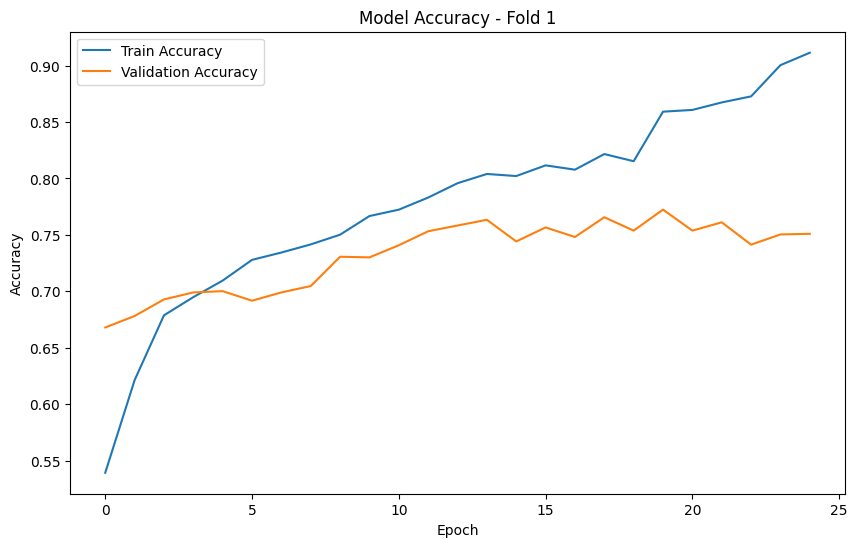

26/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2025-02-13 19:46:45.851477: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 1 Results:
Accuracy: 0.7724
Balanced Accuracy: 0.7725
MCC: 0.5493
Sensitivity: 0.8350
Specificity: 0.7099

Learned track weights for fold 1:
Sequence weight: 0.4084
ProtT5 weight: 0.5916

Fold 2/5


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
219/222 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5275 - loss: 5.2977

2025-02-13 19:46:51.463008: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5280 - loss: 5.2873 - val_accuracy: 0.6544 - val_loss: 3.5384 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5891 - loss: 3.2705 - val_accuracy: 0.6781 - val_loss: 2.1947 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6457 - loss: 2.0377 - val_accuracy: 0.7103 - val_loss: 1.4680 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6696 - loss: 1.3898 - val_accuracy: 0.7047 - val_loss: 1.1072 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6953 - loss: 1.0628 - val_accuracy: 0.7211 - val_loss: 0.9040 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7187 - loss: 0.8668 - val_accuracy: 0.7188 - val_loss: 0.8044 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7282 - loss: 0.7783 - val_accur

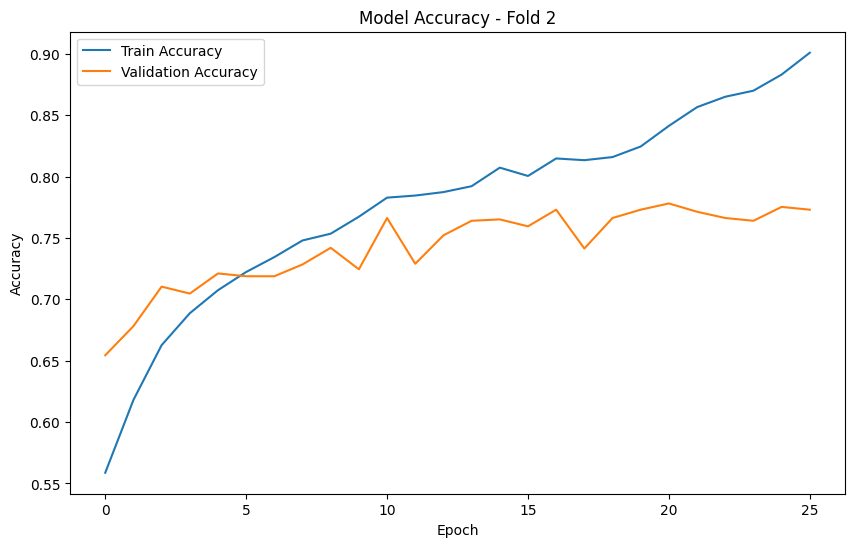

24/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2025-02-13 19:47:44.959219: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 2 Results:
Accuracy: 0.7781
Balanced Accuracy: 0.7744
MCC: 0.5506
Sensitivity: 0.8111
Specificity: 0.7378

Learned track weights for fold 2:
Sequence weight: 0.3887
ProtT5 weight: 0.6113

Fold 3/5


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
217/222 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5477 - loss: 5.1253

2025-02-13 19:47:50.886161: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5484 - loss: 5.1083 - val_accuracy: 0.6443 - val_loss: 3.2564 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6181 - loss: 2.9054 - val_accuracy: 0.6838 - val_loss: 1.8578 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6728 - loss: 1.6827 - val_accuracy: 0.7013 - val_loss: 1.2227 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6866 - loss: 1.1424 - val_accuracy: 0.7064 - val_loss: 0.9550 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7147 - loss: 0.9148 - val_accuracy: 0.7098 - val_loss: 0.8107 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7291 - loss: 0.7952 - val_accuracy: 0.7352 - val_loss: 0.7361 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7455 - loss: 0.7219 - val_accu

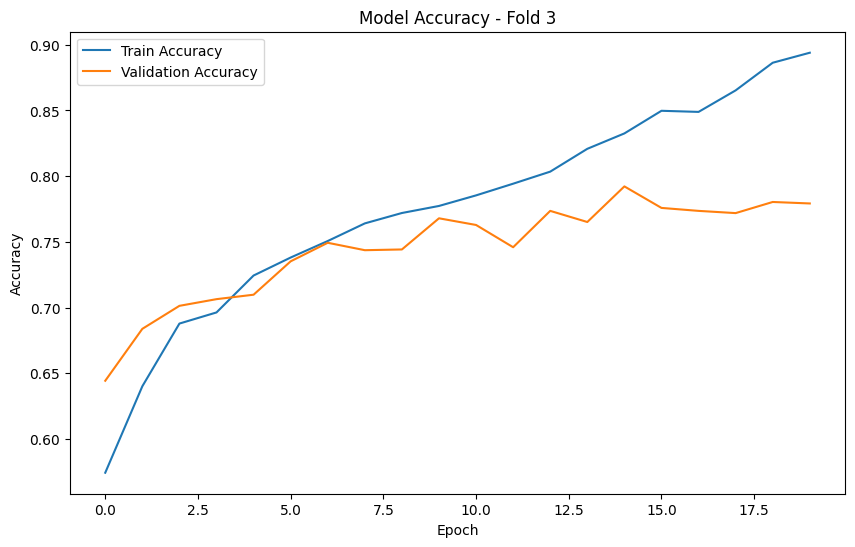

23/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2025-02-13 19:48:32.503645: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 3 Results:
Accuracy: 0.7922
Balanced Accuracy: 0.7913
MCC: 0.5852
Sensitivity: 0.8343
Specificity: 0.7483

Learned track weights for fold 3:
Sequence weight: 0.4419
ProtT5 weight: 0.5581

Fold 4/5


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
217/222 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5218 - loss: 5.1539

2025-02-13 19:48:38.261630: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5227 - loss: 5.1364 - val_accuracy: 0.6576 - val_loss: 3.2581 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6051 - loss: 2.9552 - val_accuracy: 0.7090 - val_loss: 1.9566 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6694 - loss: 1.7922 - val_accuracy: 0.7113 - val_loss: 1.2930 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6936 - loss: 1.2350 - val_accuracy: 0.7237 - val_loss: 0.9774 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7253 - loss: 0.9537 - val_accuracy: 0.7232 - val_loss: 0.8204 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7420 - loss: 0.7883 - val_accuracy: 0.7316 - val_loss: 0.7378 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7506 - loss: 0.7130 - val_accur

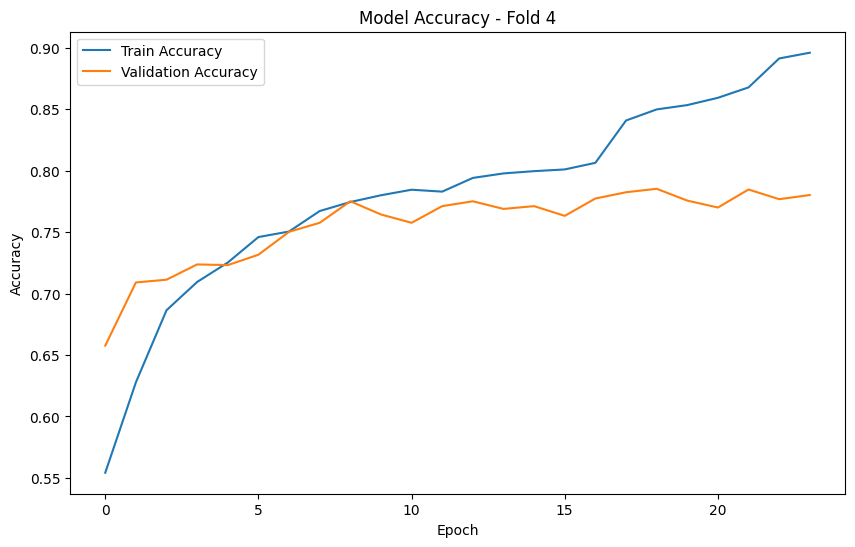

24/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2025-02-13 19:49:28.467590: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 4 Results:
Accuracy: 0.7853
Balanced Accuracy: 0.7833
MCC: 0.5733
Sensitivity: 0.8529
Specificity: 0.7136

Learned track weights for fold 4:
Sequence weight: 0.4415
ProtT5 weight: 0.5585

Fold 5/5


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
219/222 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5481 - loss: 5.1826

2025-02-13 19:49:33.995988: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5484 - loss: 5.1720 - val_accuracy: 0.6644 - val_loss: 3.3908 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6149 - loss: 3.0626 - val_accuracy: 0.6915 - val_loss: 2.0277 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6665 - loss: 1.8454 - val_accuracy: 0.7164 - val_loss: 1.3251 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6974 - loss: 1.2588 - val_accuracy: 0.7102 - val_loss: 1.0286 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6974 - loss: 0.9903 - val_accuracy: 0.7237 - val_loss: 0.8561 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7213 - loss: 0.8324 - val_accuracy: 0.7119 - val_loss: 0.7875 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7366 - loss: 0.7500 - val_accu

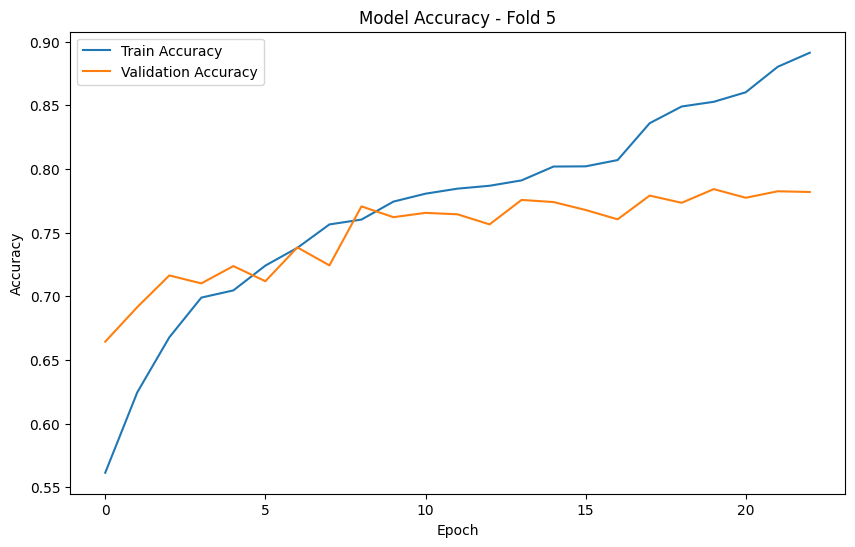

26/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2025-02-13 19:50:19.721362: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 5 Results:
Accuracy: 0.7791
Balanced Accuracy: 0.7787
MCC: 0.5575
Sensitivity: 0.7895
Specificity: 0.7679

Learned track weights for fold 5:
Sequence weight: 0.4470
ProtT5 weight: 0.5530

Average track weights across folds:
Sequence weight: 0.4255 ± 0.0230
ProtT5 weight: 0.5745 ± 0.0230

Average Cross-validation Results:
ACC: 0.7814 ± 0.0068
BALANCED_ACC: 0.7800 ± 0.0067
MCC: 0.5632 ± 0.0139
SN: 0.8246 ± 0.0220
SP: 0.7355 ± 0.0217

Final Test Set Results:
Accuracy: 0.7563
Balanced Accuracy: 0.7873
MCC: 0.3545
Sensitivity: 0.8250
Specificity: 0.7497
Confusion Matrix:
[[1872  625]
 [  42  198]]


In [13]:
if __name__ == "__main__":
    model = train_and_evaluate()